# 0. Setup Paths

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'; print("WORKSPACE_PATH       :" + WORKSPACE_PATH)
SCRIPTS_PATH = 'Tensorflow/scripts'; print("SCRIPTS_PATH         :" + SCRIPTS_PATH)
APIMODEL_PATH = 'Tensorflow/models'; print("APIMODEL_PATH        :" + APIMODEL_PATH)
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'; print("ANNOTATION_PATH      :" + ANNOTATION_PATH)
IMAGE_PATH = WORKSPACE_PATH+'/images'; print("IMAGE_PATH           :" + IMAGE_PATH)
MODEL_PATH = WORKSPACE_PATH+'/models'; print("MODEL_PATH           :" + MODEL_PATH)
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'; print("PRETRAINED_MODEL_PATH:" + PRETRAINED_MODEL_PATH)
CONFIG_PATH = MODEL_PATH+'/my_ssd_resnet50/pipeline.config'; print("CONFIG_PATH          :" + CONFIG_PATH)
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_resnet50/'; print("CHECKPOINT_PATH      :" + CHECKPOINT_PATH)

WORKSPACE_PATH       :Tensorflow/workspace
SCRIPTS_PATH         :Tensorflow/scripts
APIMODEL_PATH        :Tensorflow/models
ANNOTATION_PATH      :Tensorflow/workspace/annotations
IMAGE_PATH           :Tensorflow/workspace/images
MODEL_PATH           :Tensorflow/workspace/models
PRETRAINED_MODEL_PATH:Tensorflow/workspace/pre-trained-models
CONFIG_PATH          :Tensorflow/workspace/models/my_ssd_resnet50/pipeline.config
CHECKPOINT_PATH      :Tensorflow/workspace/models/my_ssd_resnet50/


# 1. Create Label Map

In [2]:
# isi dari label map
labels = [{'name':'BlastCell', 'id':1}, {'name':'NonBlastCell', 'id':2}]

# write label_map.pbtxt
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [3]:
#!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
#!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

In [4]:
# manual command
print('-'*127)
print('CMD FOR train.record:')
print(f"python {SCRIPTS_PATH}/generate_tfrecord.py -x {IMAGE_PATH}/train -l {ANNOTATION_PATH}/label_map.pbtxt -o {ANNOTATION_PATH}/train.record")
print('-'*127)
print('CMD FOR test.record:')
print(f"python {SCRIPTS_PATH}/generate_tfrecord.py -x {IMAGE_PATH}/test -l {ANNOTATION_PATH}/label_map.pbtxt -o {ANNOTATION_PATH}/test.record")

-------------------------------------------------------------------------------------------------------------------------------
CMD FOR train.record:
python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/images/train -l Tensorflow/workspace/annotations/label_map.pbtxt -o Tensorflow/workspace/annotations/train.record
-------------------------------------------------------------------------------------------------------------------------------
CMD FOR test.record:
python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/images/test -l Tensorflow/workspace/annotations/label_map.pbtxt -o Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [5]:
#!cd Tensorflow && git clone https://github.com/tensorflow/models

In [6]:
#import wget

In [7]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz')
#!move ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}

In [8]:
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [9]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [10]:
CUSTOM_MODEL_NAME = 'my_ssd_resnet50' 

In [11]:
#!mkdir {'Tensorflow\\workspace\\models\\'+CUSTOM_MODEL_NAME}
#!copy {PRETRAINED_MODEL_PATH+'/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

# 5. Update Config For Transfer Learning

In [12]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [13]:
# Cek ada GPU atau nga
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(physical_devices[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [14]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [15]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [16]:
# Cek bentuk pipeline-nya
config

{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.0004
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.03
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
       unmatched_threshold: 0.5
       ignore_thresholds: fal

In [17]:
'''
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  
'''

'\npipeline_config = pipeline_pb2.TrainEvalPipelineConfig()\nwith tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     \n    proto_str = f.read()                                                                                                                                                                                                                                          \n    text_format.Merge(proto_str, pipeline_config)  \n'

In [18]:
'''
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']
'''

'\npipeline_config.model.ssd.num_classes = 2\npipeline_config.train_config.batch_size = 4\npipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+\'/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0\'\npipeline_config.train_config.fine_tune_checkpoint_type = "detection"\npipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + \'/label_map.pbtxt\'\npipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + \'/train.record\']\npipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + \'/label_map.pbtxt\'\npipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + \'/test.record\']\n'

In [19]:
'''
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)
'''

'\nconfig_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        \nwith tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     \n    f.write(config_text)\n'

# 6. Train the model

In [20]:
print("terminal command for training model:\n")
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

terminal command for training model:

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_resnet50 --pipeline_config_path=Tensorflow/workspace/models/my_ssd_resnet50/pipeline.config --num_train_steps=5000


# 7. Load Train Model From Checkpoint

In [21]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [23]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-59')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect in Real-Time

In [24]:
import cv2 
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [40]:
# read by path
img = cv2.imread("Im010_1.jpg") # baca gambar
image_np = np.array(img)        # ubah ke np
#print(img)
#print(image_np)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=20,
            min_score_thresh=.65,
            agnostic_mode=False)
print(detections)

{'detection_boxes': array([[5.31413913e-01, 8.97578537e-01, 6.48633838e-01, 9.75740016e-01],
       [8.55772078e-01, 3.19850326e-01, 9.40808713e-01, 4.12044168e-01],
       [8.14515829e-01, 5.58109820e-01, 9.14776444e-01, 6.35638058e-01],
       [1.09205961e-01, 4.27456647e-02, 2.02611506e-01, 1.82082504e-01],
       [3.34569693e-01, 4.33533281e-01, 4.36958611e-01, 5.10770380e-01],
       [4.52596694e-03, 4.95182931e-01, 1.55706197e-01, 5.99729478e-01],
       [8.96135509e-01, 8.44804585e-01, 9.95488822e-01, 9.20065105e-01],
       [1.98135972e-01, 2.30995744e-01, 3.51336598e-01, 3.04000109e-01],
       [2.78920531e-01, 6.54315472e-01, 3.90511811e-01, 7.30813503e-01],
       [2.15993077e-03, 7.49608696e-01, 1.20963551e-01, 8.37584317e-01],
       [8.43974352e-01, 9.32786882e-01, 9.00370836e-01, 9.94881094e-01],
       [5.67722440e-01, 5.34228802e-01, 6.51575327e-01, 5.99635005e-01],
       [5.38644120e-02, 7.86558315e-02, 1.14637040e-01, 1.31556630e-01],
       [8.94548178e-01, 3.69342

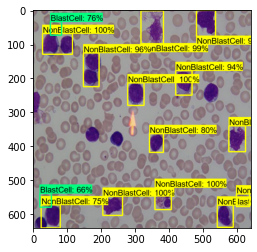

In [39]:
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# save image in same directory as ipynb
from PIL import Image
im = Image.fromarray(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
im.save("017-09.jpg")

In [ ]:
'''
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break
'''